# Sequential Data and Recurrent Neural Networks (RNN)
- Neural networks for sequences of data, e.g., speech, time series data, essentially anything that generates itself in a sequence. All time series data is sequential, but not all sequential data is time series, e.g., DNA sequences.    
- Order of the data is important, i.e., $t$ is dependent on $t_{-1}$. Normally our models demand (assume) the data is independently and identically distributed, so this is a departure which requires different techniques and models.  
- See the [Keras RNN Guide](https://keras.io/guides/working_with_rnns/) for more info.

<img src='files/diagrams/sequences.png' style='width: 600 px'>

### Use cases:
- Time series (e.g., electricity forecasting). 
- Speech processing.  
- Signal analysis.  
- Gene sequences.  
- Music generation.

### Simple Time Series Example

> Data is the S&P500 stock index, a very time series data set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

stocks = pd.read_csv('data/stocks.csv')
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16467 entries, 0 to 16466
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       16467 non-null  object 
 1   Open       16467 non-null  float64
 2   High       16467 non-null  float64
 3   Low        16467 non-null  float64
 4   Close      16467 non-null  float64
 5   Volume     16467 non-null  int64  
 6   Adj Close  16467 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 900.7+ KB


In [2]:
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks = stocks.set_index('Date')
stocks.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2015-06-12,2107.429932,2107.429932,2091.330078,2094.110107,2719400000,2094.110107
2015-06-11,2106.239990,2115.020020,2106.239990,2108.860107,3128600000,2108.860107
2015-06-10,2081.120117,2108.500000,2081.120117,2105.199951,3414320000,2105.199951
2015-06-09,2079.070068,2085.620117,2072.139893,2080.149902,3034580000,2080.149902
2015-06-08,2092.340088,2093.010010,2079.110107,2079.280029,2917150000,2079.280029


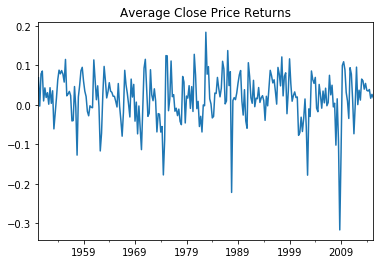

In [3]:
closePrice = stocks['Close'].resample('Q').mean()
closePrice = np.log(closePrice)
closePrice = closePrice.diff()
closePrice = closePrice[closePrice.notna()]

closePrice.plot()
plt.title('Average Close Price Returns')
plt.xlabel('')
plt.ylabel('')
plt.show()

> Might be valuable if we could predict future values?


> If you are forecasting time series, there are special considerations you need to take into account! Your time series needs to be mean/co-variance stationary. Usually when forecasting, what we'll actually be forecasting is some type of rate of change or log-difference.


### Differences from ANNs
> Not feed-forward, RNNs have loops!

> Looking at blocks (units) of memory versus neurons. 

<img src='files/diagrams/ann-vs-recurrent.png' style='height: 200 px'>

[Source: Raschka Chapter 16](https://github.com/rasbt/python-machine-learning-book-3rd-edition/tree/master/ch16/images)

#### Activations Computed with a Weight Matrix that takes $t0$ `and` $t_{-1}$


<img src='files/diagrams/recurrent-form.png' style='height: 200 px'>

[Source: Raschka Chapter 16](https://github.com/rasbt/python-machine-learning-book-3rd-edition/tree/master/ch16/images)


- Read the read sequentially, either by time or sequence ($t$).  
- At $t$, we update the state $h_{l,u}$ by calcuating the linear combination of the input feature vector and the $t-1$ state vector.  
- $h^t_{l,u}$ is calculated using $w_{l,u}$ and $u_{l,u}$ and the parameter $b_{l,u}$. $h^t_{l,u}$ is obtained after applying an activation function.  
- The activation functions can have the vanishing gradient problem, the cause and effect can be lost from longer sequences.  
- Gated RNNs protect against vanishing gradients and retain the short/long-term memory. These long short-term memory (LSTM) networks can store history more efficiently. What information that is used is learned by the network.  
- Common gates are comprised at least of memory and forget gates and the history retained is learned from these, e.g., how many lags are important in time series analysis with data that contains unknown seasonality.

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import numpy as np

# Suppress silly warnings
tf.autograph.set_verbosity(
    5, alsologtostdout=False
)

np.random.seed(10)

# Need to scale the data
cP = np.array(closePrice)
cP = cP.reshape(-1,1)
cP.shape

(261, 1)

#### Split into training and test

In [5]:
train_size = int(len(cP) * 0.80)
test_size = len(cP) - train_size

train, test = cP[0:train_size,:], cP[train_size:len(cP),:]
print(len(train), len(test))

208 53


### Function to create the data set
Pieces borrowed from: [Machine Learning Mastery Time Series Blog](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

In [6]:
def create_dataset(dataset, look_back=1):
    
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [7]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Build Models
> Notice we are using `Long-term Short-term` (LSTM) layers for recurrent networks.

In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [9]:
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=0)

### Evaluate Predictions

In [10]:
import math 
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict.shape, testPredict.shape

((206, 1), (51, 1))

In [11]:
trainY = trainY.reshape(-1,1)
trainY.shape

(206, 1)

In [12]:
testY = testY.reshape(-1,1)
testY.shape

(51, 1)

In [13]:
# Calculate root mean squared error
import math

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.05 RMSE
Test Score: 0.07 RMSE


In [14]:
results = np.concatenate((trainY, testY), axis=0)
results.shape

(257, 1)

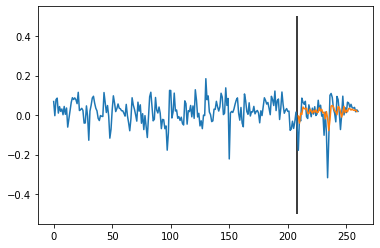

In [15]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(cP)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(cP)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(cP)-1, :] = testPredict

# plot baseline and predictions
plt.plot(cP)
plt.plot(testPredictPlot)
plt.vlines(train_size,-0.5,0.5)
plt.show()

> There are many methods for time series, see [Hyndman's Text](https://otexts.com/fpp2/) for techniques and additional non-neural network models.

### IMDB (yes, again `:)` ) for Sentiment Analysis
<img src='files/diagrams/manymany.png' style='height: 200 px'>

[Source: Raschka Chapter 16](https://github.com/rasbt/python-machine-learning-book-3rd-edition/tree/master/ch16/images)

### Load the IMDB Data
Recall it's 50,000 observations of reviews and the corresponding sentiment.

In [17]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

25000 Training sequences
25000 Validation sequences


In [18]:
x_train.shape

(25000, 200)

> Returns array with indices for the vocabulary

The index is where that word occurred. If it didn't occur, it'll be a zero.

In [19]:
x_train

array([[   5,   25,  100, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [   0,    0,    0, ...,    4, 3586,    2],
       [   0,    0,    0, ...,   12,    9,   23],
       [   0,    0,    0, ...,  204,  131,    9]], dtype=int32)

## Sparse Word Vector Data

Recall most reviews don't use the same set of words, so the matrix is going to be very sparse. We can convert the sequences to real-valued vectors that will approximate the original sparse data but be more usable for machine learning purposes. This will be more useful for longer sequences, simple categorical data likely won't have much of a benefit,

Below adds an embedding layer that is 32 dimensions (features) of a real-valued vector. It maps the data to a higher dimensional space and produces those corresponding coordinates.

[Explanation on Embeddings](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

[TensorFlow Guide to Work Embeddings](https://www.tensorflow.org/text/guide/word_embeddings)

### Embedding Alternative, the Autoencoder
> Same output as simple embedding, but uses a encoder-decoder neural network to produce an embedding layer. Another option for creating a dense feature set from sparse data.

<img src='files/diagrams/autoencoder2.png' style='height: 200 px'>

[Source: The Hundred-Page Machine Learning Book](https://www.dropbox.com/s/esprbgjm0wc5afz/Chapter7.pdf?dl=0)

> Example mapping a 5x1 array...

In [20]:
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding
input_array = np.array([4, 1, 3, 3, 3])

model = Sequential()
model.add(Embedding(5, 2, input_length=5))

input_array = np.random.randint(5, size=(1, 5))

model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)

output_array

array([[[ 0.01913018, -0.01928743],
        [-0.01919758,  0.02942536],
        [ 0.02796857, -0.03568695],
        [ 0.01913018, -0.01928743],
        [-0.03900032, -0.03623945]]], dtype=float32)

## Back to IMDB
- Input will be the sparse vocabulary but use embedding layers to create dense features.  
- Baseline using a SimpleRNN, which is a fully connected recurrent neural network.

In [24]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          640000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 644,193
Trainable params: 644,193
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
100/100 [==============================] - 9s 79ms/step - loss: 0.0481 - accuracy: 0.9965 - val_loss: 2.6998 - val_accuracy: 0.7417
Epoch 2/15
100/100 [==============================] - 8s 80ms/step - loss: 0.0466 - accuracy: 0.9964 - val_loss: 2.8362 - val_accuracy: 0.7370
Epoch 3/15
100/100 [==============================] - 8s 78ms/step - loss: 0.2055 - accuracy: 0.9714 - val_loss: 2.5163 - val_accuracy: 0.7669
Epoch 4/15
100/100 [==============================] - 8s 78ms/step - loss: 0.1788 - accuracy: 0.9723 - val_loss: 2.5153 - val_accuracy: 0.7499
Epoch 5/15
100/100 [==============================] - 8s 78ms/step - loss: 0.0804 - accuracy: 0.9880 - val_loss: 2.5003 - val_accuracy: 0.7601
Epoch 6/15
100/100 [==============================] - 8s 78ms/step - loss: 0.1871 - accuracy: 0.9722 - val_loss: 3.6758 - val_accuracy: 0.6575
Epoch 7/15
100/100 [==============================] - 8s 78ms/step - loss: 0.0968 - accuracy: 0.9844 - val_loss: 2.5921 - val_accuracy: 0.7368

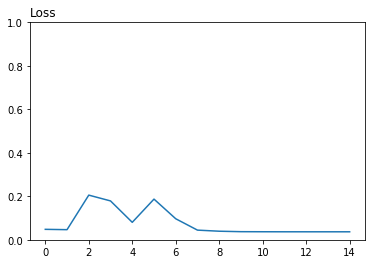

In [30]:
import datetime

st = datetime.datetime.now()

model.compile(optimizer="adam", loss="BinaryCrossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=250, epochs=15, validation_data=(x_val, y_val)
)

en = datetime.datetime.now()

el = en - st
print(f'Elapsed time: {el}')

plt.plot(history.history['loss'])
plt.title('Loss', loc='left')
plt.ylim((0,1))
plt.show()

> Definitely looks like we are overfitting - training accuracy > 98% and validation accuracy about 75%.

### Trying a LSTM model inside a Bidirectional Layer
- The Bidirectional layer makes two passes, a forward then a reverse.

In [32]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=32))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 32)          640000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 697,985
Trainable params: 697,985
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
100/100 [==============================] - 44s 418ms/step - loss: 0.5107 - accuracy: 0.7332 - val_loss: 0.3052 - val_accuracy: 0.8696
Epoch 2/15
100/100 [==============================] - 37s 373ms/step - loss: 0.2291 - accuracy: 0.9108 - val_loss: 0.3090 - val_accuracy: 0.8707
Epoch 3/15
100/100 [==============================] - 38s 383ms/step - loss: 0.1403 - accuracy: 0.9495 - val_loss: 0.3623 - val_accuracy: 0.8672
Epoch 4/15
100/100 [==============================] - 38s 377ms/step - loss: 0.0903 - accuracy: 0.9710 - val_loss: 0.4374 - val_accuracy: 0.8606
Epoch 5/15
100/100 [==============================] - 38s 386ms/step - loss: 0.0632 - accuracy: 0.9807 - val_loss: 0.4589 - val_accuracy: 0.8532
Epoch 6/15
100/100 [==============================] - 37s 370ms/step - loss: 0.0534 - accuracy: 0.9838 - val_loss: 0.5430 - val_accuracy: 0.8482
Epoch 7/15
100/100 [==============================] - 37s 375ms/step - loss: 0.0443 - accuracy: 0.9870 - val_loss: 0.6131 - val_ac

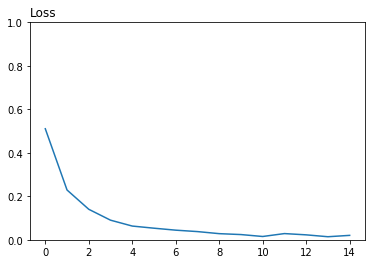

In [33]:
import datetime

st = datetime.datetime.now()

model.compile(optimizer="adam", loss="BinaryCrossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=250, epochs=15, validation_data=(x_val, y_val)
)

en = datetime.datetime.now()

el = en - st
print(f'Elapsed time: {el}')

plt.plot(history.history['loss'])
plt.title('Loss', loc='left')
plt.ylim((0,1))
plt.show()

> Much smoother loss function (that doesn't increase!).  

> 10 pt improvement in accuracy over the SimpleRNN